In [175]:
import requests
import time
import os
import config
from urllib.parse import urlparse, parse_qs
from IPython.display import display, HTML
import pandas as pd
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

#### Steps:
1. Retrieve activities from Strava
2. Handle null values
3. Handle data types

#### Metrics to calculate:
1. Intensity Factor (IF)
2. Training Stress Score (TSS)
3. Chronic Training Load (CTL)
4. Acute Training Load (ATL)
5. Training Stress Balance (TSB)

#### Normalized Power
$$\text{NP} = \left( \frac{\sum (\text{30-second Rolling Average})^4}{\text{number of data points}} \right)^{0.25}$$

#### Intensity Factor
$$\text{IF} = \frac{\text{NP}}{\text{FTP}}$$

#### Training Stress Score (TSS)
TSS is a composite number that takes into account the intensity and duration of a workout to quantify its overall training load. It helps athletes understand how hard a workout was on their body. The calculation for TSS differs depending on the type of activity:

$$
\text{TSS} = \frac{\text{Workout Duration (s)} \times \text{Normalized Power (NP)} \times \text{Intensity Factor (IF)}}{\text{FTP} \times 3600} \times 100
$$
- **Normalized Power (NP)**: A weighted average of power output that accounts for variations in intensity.
- **Intensity Factor (IF)**: Ratio of the normalized power to the athlete's Functional Threshold Power (FTP).
- **Functional Threshold Power (FTP)**: The highest power an athlete can maintain in a quasi-steady state for approximately one hour.
- **Workout Duration**: The total time of the workout in seconds.

#### Fitness (Chronic Training Load - CTL)
Fitness, represented as CTL, is the rolling average of TSS over a longer period, typically 42 days. It reflects the cumulative training load and how fit the athlete is.

$$\text{CTL} = \frac{\text{Sum of TSS over the past 42 days}}{42}$$

#### Fatigue (Acute Training Load - ATL)
Fatigue, represented as ATL, is the rolling average of TSS over a shorter period, typically 7 days. It indicates the short-term training load and how fatigued the athlete is.

$$\text{ATL} = \frac{\text{Sum of TSS over the past 7 days}}{7}$$

#### Form (Training Stress Balance - TSB)
Form, represented as TSB, is the difference between CTL and ATL. It shows the balance between fitness and fatigue, indicating how well-rested and ready for performance the athlete is.

$$\text{TSB} = \text{CTL} - \text{ATL}$$

- **Positive TSB**: Indicates that the athlete is well-rested and in good form.
- **Negative TSB**: Indicates that the athlete is fatigued and may need recovery.
- **Ideal range when training is -10 to -30**

#### Practical Example

1. **Cycling Workout**: 
   - Duration: 1.5 hours (5400 seconds)
   - NP: 250 watts
   - IF: 0.85
   - FTP: 300 watts

$$\text{TSS} = \frac{5400 \times 250 \times 0.85}{300 \times 3600} \times 100 = 106.25$$

By accumulating TSS values over time, TrainingPeaks can model CTL, ATL, and TSB to provide a comprehensive view of an athlete’s fitness, fatigue, and form, enabling better training decisions and performance optimization.

In [113]:
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
redirect_uri = 'http://localhost:8000' # in Strava settings it is localhost:8000

# Step 1: Generate the authorization URL
auth_url = (f"https://www.strava.com/oauth/authorize"
            f"?client_id={client_id}&redirect_uri={redirect_uri}"
            f"&response_type=code&scope=activity:read_all")
display(HTML(f'<a href="{auth_url}" target="_blank">Click here to authorize with Strava</a>'))


In [216]:
redirect_response = input("Paste the full redirect URL here: ")
parsed_url = urlparse(redirect_response)
authorization_code = parse_qs(parsed_url.query)['code'][0]

# Step 2: Exchange the authorization code for an access token
token_url = 'https://www.strava.com/oauth/token'
payload = {
    'client_id': client_id,
    'client_secret': client_secret,
    'code': authorization_code,
    'grant_type': 'authorization_code'
}

response = requests.post(token_url, data=payload)
access_token = response.json()['access_token']
print(f"Access Token: {access_token}")

Paste the full redirect URL here:  http://localhost:8000/?state=&code=d8e4a482fff7464e0951e294c0092a51136ca891&scope=read,activity:read_all


Access Token: 5fa4e68d7fd9d1b0db9dac2be8dbb75b4c94a644


In [289]:
def get_strava_activities(access_token):
    activities = []
    page = 1
    while True:
        url = f"https://www.strava.com/api/v3/athlete/activities"
        headers = {'Authorization': f'Bearer {access_token}'}
        params = {'per_page': 200, 'page': page}
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code != 200:
            print("Failed to retrieve activities:", response.content)
            break
        
        data = response.json()
        
        if not data:
            break
        
        activities.extend(data)
        page += 1
    
    return activities


def get_strava_streams(access_token, activity_id, keys):
    max_retries = 5  # Number of retries for rate limiting
    retry_delay = 60  # Delay in seconds between retries

    url = f"https://www.strava.com/api/v3/activities/{activity_id}/streams"
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {
        'keys': keys,
        'key_by_type': 'true'
    }

    while True:
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 429:  # Rate limit exceeded
            print("Rate limit exceeded. Retrying...")
            max_retries -= 1
            if max_retries == 0:
                print("Max retries reached. Exiting.")
                break
            time.sleep(retry_delay)
            continue
        
        if response.status_code != 200:
            print("Failed to retrieve activities:", response.content)
            break

        data = response.json()

        if not data:
            break

        if keys not in data:
            print(f"{keys} stream not available.")
            return None

        return data[keys]['data']

def get_multiple_streams(access_token, activity_ids, keys):
    streams = []
    for activity_id in activity_ids:
        stream = get_strava_streams(access_token, activity_id, keys)#[keys]['data']
        streams.append(stream)

    return streams



def plot_heatmap(coordinates_list):
    tiles = 'https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png'
    attr = '&copy; <a href="https://www.stadiamaps.com/" target="_blank">Stadia Maps</a> &copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
    m = folium.Map(location=(52.5740, 13.4101), tiles=tiles, attr=attr)
    for coordinates in coordinates_list:
        if coordinates != None:
            folium.PolyLine(coordinates, color='#EB33FF', weight=2, opacity=0.6).add_to(m)
    return m


def format_dataframe(df):
    df = df.copy()

    # Format distance, speed and duration measurements.
    df.distance = df.distance / 1000
    df.average_speed = df.average_speed * 3600 / 1000
    df.max_speed = df.max_speed * 3600 / 1000
    df.moving_time = df.moving_time / 3600
    df.elapsed_time = df.elapsed_time / 3600

    # Format date / time columns.
    df['date'] = pd.to_datetime(df['start_date_local']).dt.strftime('%Y-%m-%d')
    
    return df

def get_ftp(date):
    ftp_changes = {
        '2021-10-25': 211,
        '2022-01-30': 237,
        '2022-12-17': 249,
        '2023-03-25': 265,
        '2023-10-05': 256,
        '2023-11-22': 262,
        '2024-02-14': 266,
        '2024-03-13': 272,
        '2024-04-15': 277,
        '2024-06-27': 279,
    }
    
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d')
    elif isinstance(date, pd.Timestamp):
        date = date.to_pydatetime()
    
    sorted_dates = sorted(ftp_changes.keys())
    
    for i, change_date in enumerate(sorted_dates):
        change_date = datetime.strptime(change_date, '%Y-%m-%d')
        
        if date < change_date:
            if i == 0:
                return ftp_changes[sorted_dates[0]]
            return ftp_changes[sorted_dates[i-1]]
        
        if i == len(sorted_dates) - 1 or date < datetime.strptime(sorted_dates[i+1], '%Y-%m-%d'):
            return ftp_changes[sorted_dates[i]]
    
    return None  # This should never be reached if the input is valid


def ftp_if_tss(df):
    df = df.copy()
    df['ftp'] = df['date'].apply(get_ftp)
    df['intensity_factor'] = df.weighted_average_watts / df.ftp
    df['tss'] = (((df.moving_time * 3600) * df.weighted_average_watts * df.intensity_factor) / (df.ftp * 3600)) * 100
    return df


def resample_activities(df, cols_to_resample, agg='sum', period='D'):
    df = df.copy()
    
    existing_cols = df.columns
    cols = []

    for col in existing_cols:
        if col in cols_to_resample:
            cols.append(col)
    
    df = df.groupby(by='date')[cols].agg(agg).sort_index()
    df.index = pd.to_datetime(df.index)
    df = df.resample(period).agg(agg).fillna(0) # For weekly resampling this uses the label='right' argument by default
    return df


def ctl_atl_tsb(df):
    df = df.copy()
    df['chronic_training_load'] = df.tss.rolling(window=42).sum() / 42
    df['acute_training_load'] = df.tss.rolling(window=7).sum() / 7
    df['training_stress_balance'] = df.chronic_training_load - df.acute_training_load
    return df


def training_load_plot(df):
    # Create a subplot figure with 2 rows, 1 column, shared x-axes, and custom titles
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        row_heights=[0.3, 0.3, 0.4])
    
    
    # Create traces for each data series
    traces = [
        go.Bar(x=df.index, y=df['tss'], name='TSS', visible=True),
        go.Scatter(x=df.index, y=df['chronic_training_load'], name='Chronic Training Load', visible=True),
        go.Scatter(x=df.index, y=df['acute_training_load'], name='Acute Training Load', visible=True),
        go.Scatter(x=df.index, y=df['training_stress_balance'], name='Training Stress Balance', visible=True)
    ]
    
    # Add traces to the appropriate subplots
    fig.add_trace(traces[0], row=1, col=1)  # TSS bar chart
    fig.add_trace(traces[1], row=2, col=1)  # Chronic Training Load line
    fig.add_trace(traces[2], row=2, col=1)  # Acute Training Load line
    fig.add_trace(traces[3], row=3, col=1)  # Training Stress Balance line
    
    # Update the layout of the figure
    fig.update_layout(
        xaxis3=dict(  # Configure the x-axis for the second subplot
            rangeselector=dict(  # Add buttons for quick date range selection
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ]),
                x=0.0, y=-0.2, xanchor='left', yanchor='top'
            ),
            rangeslider=dict(visible=True, thickness=0.05),  # Hide the range slider
            type="date"  # Set the axis type to date
        ),
        autosize=False,  # Disable auto-sizing
        height=800,  # Set the height of the figure
        width=1100  # Set the width of the figure
    )

    # ['top left', 'top center', 'top right', 'middle left', 'middle center', 'middle right', 'bottom left', 'bottom center', 'bottom right', 'start', 'middle', 'end']
    
    fig.add_hrect(y0=5, y1=20, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="blue", opacity=0.3, label=dict(text='hello', textposition='middle right')) # Fresh
    fig.add_hrect(y0=-10, y1=5, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="grey", opacity=0.3) # Grey zone    
    fig.add_hrect(y0=-10, y1=-30, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="green", opacity=0.4) # Optimal
    fig.add_hrect(y0=-100, y1=-30, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="red", opacity=0.3) # High risk
    
    # Return the figure
    return fig


def make_metrics_plot(df):
    fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                            row_heights=[0.2, 0.2, 0.2, 0.2, 0.2])
    
    traces = [
        go.Scatter(x=monthly.index, y=monthly.average_watts, name='Average Power', visible=True),
        go.Scatter(x=monthly.index, y=monthly.weighted_average_watts, name='Weighted Average Power', visible=True),
        go.Scatter(x=monthly.index, y=monthly.average_cadence, name='Average Cadence'),
        go.Scatter(x=monthly.index, y=monthly.average_speed, name='Average Speed'),
        go.Scatter(x=monthly.index, y=monthly.average_heartrate, name='Average Heartrate'),
        go.Scatter(x=monthly.index, y=monthly.max_heartrate, name='Average Max. Heartrate')
    ]
    
    fig.add_trace(traces[0], row=1, col=1)
    fig.add_trace(traces[1], row=1, col=1)
    fig.add_trace(traces[2], row=2, col=1)
    fig.add_trace(traces[3], row=3, col=1)
    fig.add_trace(traces[4], row=4, col=1)
    fig.add_trace(traces[5], row=5, col=1)
    
    fig.update_layout(
            xaxis5=dict(  # Configure the x-axis for the second subplot
                rangeselector=dict(  # Add buttons for quick date range selection
                    buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all")
                    ]),
                    x=0.0, y=-0.2, xanchor='left', yanchor='top'
                ),
                rangeslider=dict(visible=True, thickness=0.05),  # Hide the range slider
                type="date"  # Set the axis type to date
            ),
            autosize=False,  # Disable auto-sizing
            height=800,  # Set the height of the figure
            width=1100  # Set the width of the figure
        )
    
    return fig


In [115]:
activities = get_strava_activities(access_token)

In [117]:
df = pd.DataFrame(activities)

unique_sports = ['Ride', 'Swim', 'Hike', 'VirtualRide', 'MountainBikeRide', 'Run', 'WeightTraining', 'Yoga', 'Walk']
df = df[(df.sport_type == 'Ride') | (df.sport_type == 'VirtualRide') | (df.sport_type == 'MountainBikeRide')]
df.head()

resource_state                                athlete            name  \
0               2  {'id': 58588489, 'resource_state': 1}         Cycling   
1               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
2               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
3               2  {'id': 58588489, 'resource_state': 1}         Cycling   
4               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   

   distance  moving_time  elapsed_time  total_elevation_gain  type sport_type  \
0   91408.9        12654         15645                 168.0  Ride       Ride   
1   70574.3         9210          9661                 155.0  Ride       Ride   
2   29917.5         5273          5730                  37.0  Ride       Ride   
3   94784.0        13688         16489                 200.0  Ride       Ride   
4   44583.8         5841          7219                  53.0  Ride       Ride   

   workout_type  ...  elev_high elev_low    upload_id upload_id_str  \
0           NaN  ...       88.2     52.4  12633653932   12633653932   
1           NaN  ...      100.6     55.6  12625352805   12625352805   
2           NaN  ...       62.4     36.8  12617814448   12617814448   
3           NaN  ...       77.8     47.2  12609651027   12609651027   
4           NaN  ...       71.6     38.2  12601138686   12601138686   

                                         external_id from_accepted_tag  \
0  2024-07-09-095508-ELEMNT_ROAM_C120-26-02024070...             False   
1           87ef5788-ea58-4185-9da1-4ae08c78379e.fit             False   
2           bf6404c1-b051-4da7-ad6e-a7c3be59f1bc.fit             False   
3  2024-07-06-110641-ELEMNT_ROAM_C120-23-02024070...             False   
4           3335f3d2-7524-41cd-b424-c5907bb9a925.fit             False   

  pr_count total_photo_count  has_kudoed  suffer_score  
0       27                 0       False          93.0  
1       25                 0       False         126.0  
2        0                 0       False          13.0  
3       15                 0       False         140.0  
4       13                 0       False          92.0  

[5 rows x 57 columns]

In [118]:
df = format_dataframe(df)
df = ftp_if_tss(df)
df.head()

resource_state                                athlete            name  \
0               2  {'id': 58588489, 'resource_state': 1}         Cycling   
1               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
2               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
3               2  {'id': 58588489, 'resource_state': 1}         Cycling   
4               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   

   distance  moving_time  elapsed_time  total_elevation_gain  type sport_type  \
0   91.4089     3.515000      4.345833                 168.0  Ride       Ride   
1   70.5743     2.558333      2.683611                 155.0  Ride       Ride   
2   29.9175     1.464722      1.591667                  37.0  Ride       Ride   
3   94.7840     3.802222      4.580278                 200.0  Ride       Ride   
4   44.5838     1.622500      2.005278                  53.0  Ride       Ride   

   workout_type  ...                                        external_id  \
0           NaN  ...  2024-07-09-095508-ELEMNT_ROAM_C120-26-02024070...   
1           NaN  ...           87ef5788-ea58-4185-9da1-4ae08c78379e.fit   
2           NaN  ...           bf6404c1-b051-4da7-ad6e-a7c3be59f1bc.fit   
3           NaN  ...  2024-07-06-110641-ELEMNT_ROAM_C120-23-02024070...   
4           NaN  ...           3335f3d2-7524-41cd-b424-c5907bb9a925.fit   

  from_accepted_tag pr_count total_photo_count  has_kudoed suffer_score  \
0             False       27                 0       False         93.0   
1             False       25                 0       False        126.0   
2             False        0                 0       False         13.0   
3             False       15                 0       False        140.0   
4             False       13                 0       False         92.0   

         date  ftp  intensity_factor         tss  
0  2024-07-09  279          0.598566  125.935991  
1  2024-07-08  279          0.731183  136.775735  
2  2024-07-07  279          0.422939   26.200578  
3  2024-07-06  279          0.630824  151.305399  
4  2024-07-05  279          0.759857   93.680246  

[5 rows x 61 columns]

In [120]:
sum_cols = ['distance', 'moving_time', 'total_elevation_gain', 'kilojoules', 'suffer_score', 'tss']
mean_cols = ['average_watts', 'weighted_average_watts', 'average_cadence', 'average_heartrate', 'max_heartrate', 'average_speed', 'max_speed']
load_cols = ['chronic_training_load', 'acute_training_load', 'training_stress_balance']

In [121]:
daily_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='D')
daily_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='D')
daily_sum_with_load = ctl_atl_tsb(daily_sum).fillna(0)

daily = pd.concat([daily_sum_with_load, daily_mean], axis=1)
daily

distance  moving_time  total_elevation_gain  kilojoules  \
date                                                                  
2020-10-03   31.6086     1.378889                 115.0         0.0   
2020-10-04   23.4551     1.254167                  47.9         0.0   
2020-10-05    0.0000     0.000000                   0.0         0.0   
2020-10-06    0.0000     0.000000                   0.0         0.0   
2020-10-07    0.0000     0.000000                   0.0         0.0   
...              ...          ...                   ...         ...   
2024-07-05   44.5838     1.622500                  53.0      1218.1   
2024-07-06   94.7840     3.802222                 200.0      2323.4   
2024-07-07   29.9175     1.464722                  37.0       585.6   
2024-07-08   70.5743     2.558333                 155.0      1826.7   
2024-07-09   91.4089     3.515000                 168.0      2078.5   

            suffer_score         tss  chronic_training_load  \
date                                                          
2020-10-03          89.0    0.000000               0.000000   
2020-10-04           0.0    0.000000               0.000000   
2020-10-05           0.0    0.000000               0.000000   
2020-10-06           0.0    0.000000               0.000000   
2020-10-07           0.0    0.000000               0.000000   
...                  ...         ...                    ...   
2024-07-05          92.0   93.680246              55.109482   
2024-07-06         140.0  151.305399              58.711991   
2024-07-07          13.0   26.200578              58.285527   
2024-07-08         126.0  136.775735              60.081537   
2024-07-09          93.0  125.935991              63.080013   

            acute_training_load  training_stress_balance  average_speed  \
date                                                                      
2020-10-03             0.000000                 0.000000        22.9248   
2020-10-04             0.000000                 0.000000        18.7020   
2020-10-05             0.000000                 0.000000         0.0000   
2020-10-06             0.000000                 0.000000         0.0000   
2020-10-07             0.000000                 0.000000         0.0000   
...                         ...                      ...            ...   
2024-07-05            58.479633                -3.370152        27.4788   
2024-07-06            45.114726                13.597265        24.9300   
2024-07-07            48.857665                 9.427861        20.4264   
2024-07-08            58.280280                 1.801257        27.5868   
2024-07-09            76.271136               -13.191123        26.0064   

            max_speed  average_cadence  average_watts  weighted_average_watts  \
date                                                                            
2020-10-03    56.8800              0.0            0.0                     0.0   
2020-10-04    28.8000              0.0            0.0                     0.0   
2020-10-05     0.0000              0.0            0.0                     0.0   
2020-10-06     0.0000              0.0            0.0                     0.0   
2020-10-07     0.0000              0.0            0.0                     0.0   
...               ...              ...            ...                     ...   
2024-07-05    42.8904             85.3          208.5                   212.0   
2024-07-06    48.6648             81.8          169.7                   176.0   
2024-07-07    33.3576             61.7          111.1                   118.0   
2024-07-08    59.0256             84.9          198.3                   204.0   
2024-07-09    55.4004             83.0          164.3                   167.0   

            average_heartrate  max_heartrate  
date                                          
2020-10-03                0.0            0.0  
2020-10-04                0.0            0.0  
2020-10-05                0.0            0.0  
202

In [122]:
weekly_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='W')
weekly_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='W')
daily_load = daily[load_cols]
weekly_load = resample_activities(daily_load, cols_to_resample=load_cols, agg='mean', period='W')
weekly = pd.concat([weekly_sum, weekly_load, weekly_mean], axis=1)
weekly.tail()

distance  moving_time  total_elevation_gain  kilojoules  \
date                                                                  
2024-06-16  274.9061     9.281667                 599.0      6580.0   
2024-06-23  218.6236     7.936667                 208.0      4810.3   
2024-06-30  231.2338     7.870000                 464.0      5632.6   
2024-07-07  209.4676     8.139444                 290.0      5016.3   
2024-07-14  161.9832     6.073333                 323.0      3905.2   

            suffer_score         tss  chronic_training_load  \
date                                                          
2024-06-16         395.0  505.526297              46.693789   
2024-06-23         231.0  323.347839              48.188482   
2024-06-30         316.0  431.941333              56.260625   
2024-07-07         316.0  342.003658              57.570752   
2024-07-14         219.0  262.711726              61.580775   

            acute_training_load  training_stress_balance  average_speed  \
date                                                                      
2024-06-16            65.454430               -18.760641        30.0384   
2024-06-23            58.441360               -10.252878        28.3275   
2024-06-30            61.181888                -4.921263        29.9196   
2024-07-07            54.751882                 2.818870        26.2449   
2024-07-14            67.275708                -5.694933        26.7966   

            max_speed  average_cadence  average_watts  weighted_average_watts  \
date                                                                            
2024-06-16    52.8516           91.425        199.375                  211.00   
2024-06-23    48.0051           83.900        171.950                  176.75   
2024-06-30    46.7469           88.525        196.450                  207.50   
2024-07-07    40.0194           79.375        171.725                  179.00   
2024-07-14    57.2130           83.950        181.300                  185.50   

            average_heartrate  max_heartrate  
date                                          
2024-06-16             131.00         157.25  
2024-06-23             118.25         136.75  
2024-06-30             130.25         152.25  
2024-07-07             122.40         143.75  
2024-07-14             127.45         150.50

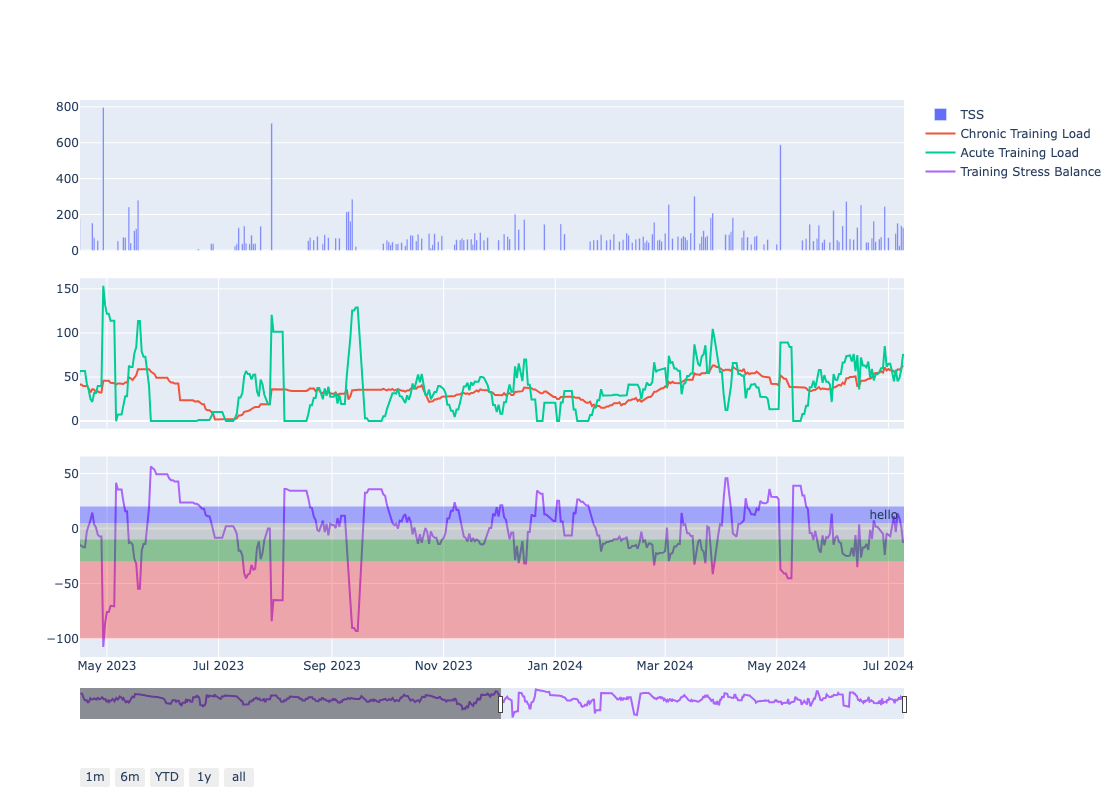

In [123]:
daily = daily[daily.index >= '2022-01-01']
training_load_plot(daily)

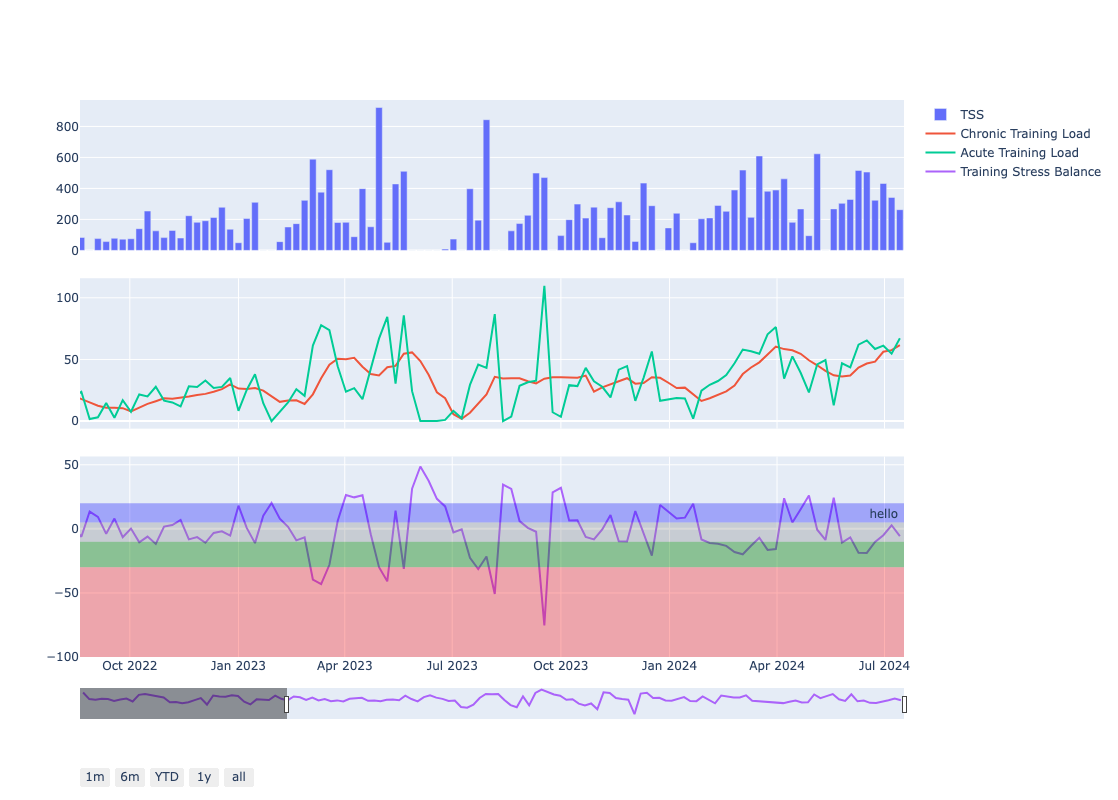

In [124]:
weekly = weekly[weekly.index >= '2022-01-01']
training_load_plot(weekly)

In [44]:
weekly.describe()

distance  moving_time  total_elevation_gain    kilojoules  \
count  133.000000   133.000000            133.000000    133.000000   
mean   121.234222     4.799703            427.185714   2682.602256   
std     94.449267     4.277708           1052.041735   2282.542332   
min      0.000000     0.000000              0.000000      0.000000   
25%     41.765500     1.500000              0.000000    865.500000   
50%    109.204900     3.921111            141.000000   2322.400000   
75%    191.591200     7.122778            331.000000   3827.800000   
max    425.361400    23.536667           7810.000000  11152.900000   

       suffer_score         tss  chronic_training_load  acute_training_load  \
count    133.000000  133.000000             133.000000           133.000000   
mean     187.902256  206.426981              29.292545            29.583147   
std      186.202027  180.598884              13.664442            22.176953   
min        0.000000    0.000000               1.930362             0.000000   
25%       68.000000   72.448788              18.519116            14.734411   
50%      163.000000  181.151628              27.706647            27.200912   
75%      284.000000  303.648808              36.839031            42.271831   
max     1580.000000  922.184736              60.468367           109.776431   

       training_stress_balance  average_speed   max_speed  average_cadence  \
count               133.000000     133.000000  133.000000       133.000000   
mean                 -0.290602      23.002933   37.758464        69.729292   
std                  18.873990      10.162756   18.033767        33.483375   
min                 -75.383405       0.000000    0.000000         0.000000   
25%                 -10.644685      22.878000   35.582400        75.050000   
50%                  -0.894179      27.443700   40.586400        84.100000   
75%                  13.349845      29.075400   47.044800        89.400000   
max                  48.674956      31.386000   73.497600        98.700000   

       average_watts  weighted_average_watts  average_heartrate  max_heartrate  
count     133.000000              133.000000         133.000000     133.000000  
mean      141.590971              153.907018         108.333484     128.954511  
std        64.381269               74.724257          46.508603      55.181521  
min         0.000000                0.000000           0.000000       0.000000  
25%       139.633333              160.000000         118.250000     140.500000  
50%       165.720000              183.400000         126.800000     151.750000  
75%       179.320000              201.000000         131.575000     157.250000  
max       215.550000              230.000000         143.800000     171.000000

In [125]:
monthly_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='ME')
monthly_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='ME')
monthly = pd.concat([monthly_mean, monthly_sum], axis=1)
monthly.tail()

average_speed  max_speed  average_cadence  average_watts  \
date                                                                   
2024-03-31      29.323906  38.845271        88.647059     182.500000   
2024-04-30      28.059000  42.973500        86.875000     187.883333   
2024-05-31      28.138582  47.412327        88.863636     188.336364   
2024-06-30      29.480400  50.131482        88.570588     189.488235   
2024-07-31      26.428800  45.750600        80.900000     174.916667   

            weighted_average_watts  average_heartrate  max_heartrate  \
date                                                                   
2024-03-31              193.823529         128.576471     149.176471   
2024-04-30              207.083333         129.841667     155.416667   
2024-05-31              196.909091         134.609091     158.181818   
2024-06-30              199.352941         127.876471     150.117647   
2024-07-31              181.166667         124.083333     146.000000   

             distance  moving_time  total_elevation_gain  kilojoules  \
date                                                                   
2024-03-31  1068.1895    38.908333                1415.0     25327.0   
2024-04-30   508.5585    18.832222                 662.0     12597.0   
2024-05-31   712.6546    28.408333                4261.0     17947.8   
2024-06-30  1149.2356    39.508333                2334.0     26890.4   
2024-07-31   371.4508    14.212778                 613.0      8921.5   

            suffer_score          tss  
date                                   
2024-03-31        1454.0  1945.203463  
2024-04-30         710.0  1005.071994  
2024-05-31        2427.0  1302.340980  
2024-06-30        1679.0  1998.617256  
2024-07-31         535.0   604.715385

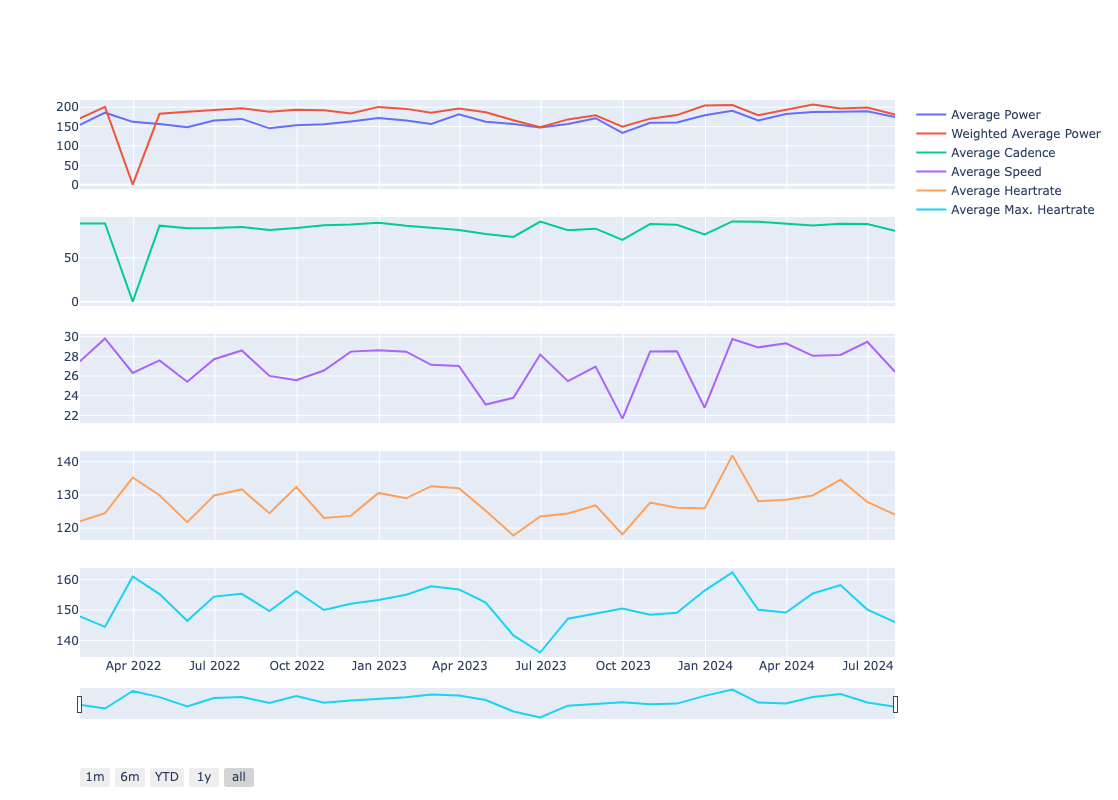

In [126]:
monthly = monthly[monthly.index >= '2022-01-01']
make_metrics_plot(monthly)

In [287]:
keys = 'latlng'
activity_ids = df.id[:50]
streams = get_multiple_streams(access_token, activity_ids, keys)

latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.
latlng stream not available.


In [290]:
plot_heatmap(streams)